In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress

# Calibrating Frequency / Voltage

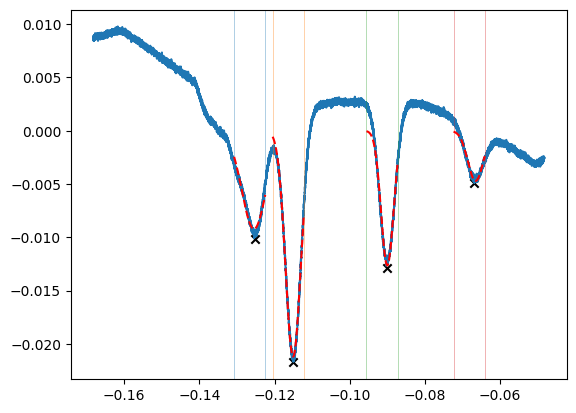

In [76]:
dataframe = read_csv("4_4_1-V2.CSV", names=["t","c1", "c2"])    
dataframe.drop(dataframe.index[[0]], inplace=True)
dataframe = dataframe.astype(float)

data = dataframe.values
t, c1, c2 = data[:, 0], data[:, 1], data[:, 2]

# Find peaks
peaks = find_peaks(-c2, height=0.004, distance=10000)[0]

xpeaks = np.array([t[i] for i in peaks])
ypeaks = np.array([c2[i] for i in peaks])

peakVoltages = np.array([c1[i] for i in peaks])

# fit gaussian to each peak (in datapoints)
peak_width = 6000
gaussian_fit_boundaries = [(int(i - peak_width), int(i + peak_width / 2)) for i in peaks]

def gaussian(vL, A, v0, vD):
	return - A * np.exp(-4 * np.log(2) * pow((vL - v0) / vD, 2))

for i, (LB, UB) in enumerate(gaussian_fit_boundaries):
    initialguess = 0.003, xpeaks[i], 0.01 / 2
    (A, v0, vD), _ = curve_fit(gaussian, t[LB:UB], c2[LB:UB], initialguess)

    x_gaussian_fit = np.linspace(t[LB], t[UB], num=1000)
    y_gaussian_fit = gaussian(x_gaussian_fit, A, v0, vD)

    plt.plot(x_gaussian_fit, y_gaussian_fit, '--', c='red', zorder=100)


plt.scatter(xpeaks, ypeaks, marker='x', c='black')
plt.plot(t[::10], c2[::10])

# plot gaussian_fit_boundaries
for peak_number, boundaries in enumerate(gaussian_fit_boundaries):
    for bound in boundaries:
        plt.axvline(x=t[bound], color='C'+ str(peak_number), alpha=0.5, linewidth=0.5)

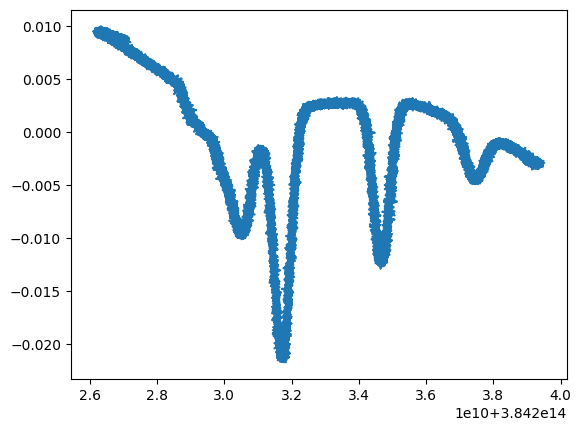

In [43]:
f0 = 384.2304844685e12
f1 = f0 + 1.296117462789e9
f2 = f1 + 3.035732439e9 
f3 = f2 + 2.500832709015e9
peakFrequencies = np.array([f0,f1,f2,f3])

df_dv, intercept, _, _, _ = linregress(peakVoltages, peakFrequencies)

freq = c1 * df_dv + intercept
plt.plot(freq[::1], c2[::1])
